In [ ]:
import os
import re
import json
import math
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt


class Account:
    """Базовый банковский счёт: операции, история, загрузка и очистка транзакций."""

    OP_DEPOSIT = "deposit"
    OP_WITHDRAW = "withdraw"
    OP_INTEREST = "interest"
    STATUS_SUCCESS = "success"
    STATUS_FAIL = "fail"
    DATE_FORMAT = "%Y-%m-%d %H:%M:%S"

    _account_counter = 1000

    def __init__(self, account_holder: str, balance: float = 0.0):
        self._validate_name(account_holder)
        if balance < 0:
            raise ValueError("Начальный баланс не может быть отрицательным.")

        Account._account_counter += 1
        self.account_number = f"ACC-{Account._account_counter}"
        self.holder = account_holder
        self._balance = float(balance)
        self.operations_history = []
        self.account_type = "basic"

    def _validate_name(self, name):
        """Имя должно быть в формате 'Имя Фамилия', кириллица или латиница, с заглавных."""
        pattern = r"^[A-ZА-ЯЁ][a-zа-яё]+ [A-ZА-ЯЁ][a-zа-яё]+$"
        if not re.match(pattern, name.strip()):
            raise ValueError("Имя владельца должно быть в формате 'Имя Фамилия'.")

    def _log_operation(self, operation_type: str, amount: float, status: str):
        self.operations_history.append(
            {
                "type": operation_type,
                "amount": amount,
                "datetime": datetime.now().strftime(self.DATE_FORMAT),
                "balance_after": round(self._balance, 2),
                "status": status,
            }
        )

    def deposit(self, amount: float):
        if amount <= 0:
            self._log_operation(self.OP_DEPOSIT, amount, self.STATUS_FAIL)
            raise ValueError("Сумма пополнения должна быть положительной.")
        self._balance += amount
        self._log_operation(self.OP_DEPOSIT, amount, self.STATUS_SUCCESS)
        return self._balance

    def withdraw(self, amount: float):
        if amount <= 0:
            self._log_operation(self.OP_WITHDRAW, amount, self.STATUS_FAIL)
            raise ValueError("Сумма вывода должна быть положительной.")
        if amount > self._balance:
            self._log_operation(self.OP_WITHDRAW, amount, self.STATUS_FAIL)
            raise ValueError("Недостаточно средств на счёте.")
        self._balance -= amount
        self._log_operation(self.OP_WITHDRAW, amount, self.STATUS_SUCCESS)
        return self._balance

    def get_balance(self) -> float:
        return self._balance

    def get_history(self):
        formatted = []
        for op in self.operations_history:
            line = (f"[{op['datetime']}] {op['type'].capitalize()} на {op['amount']}₽ "
                    f"→ баланс: {round(op['balance_after'], 2)}₽ ({op['status']})")
            formatted.append(line)
        return "\n".join(formatted)

    def get_large_transactions(self, n: int = 5):
        if not self.operations_history:
            print("История пуста.")
            return []

        df = pd.DataFrame(self.operations_history)

        df_sorted = df.sort_values(
            by=["amount", "datetime"], ascending=[False, False]
        ).head(n)

        print(f"\nТоп-{n} крупных операций для {self.holder}:")
        for _, row in df_sorted.iterrows():
            dt = row["datetime"]
            date_str = (
                dt.strftime(self.DATE_FORMAT) if isinstance(dt, datetime) else str(dt)
            )
            print(
                f"{date_str} | {row['type']:>8} | {row['amount']:>10.2f} | "
                f"Баланс: {row['balance_after']:>10.2f} | Статус: {row['status']}"
            )

    # ---- Очистка грязных данных ----
    def clean_history(self, transactions: list) -> list:
        """Базовая очистка: допускаются только deposit и withdraw."""
        allowed_types = {self.OP_DEPOSIT, self.OP_WITHDRAW}
        return self._clean_generic(transactions, allowed_types)

    def _clean_generic(self, transactions: list, allowed_types: set) -> list:
        clean_ops = []

        for op in transactions:
            if not isinstance(op, dict):
                continue

            op_type = str(op.get("operation", "")).strip().lower()
            if op_type not in allowed_types:
                continue

            # --- Сумма ---
            try:
                amount = float(op.get("amount", 0))
                if not math.isfinite(amount) or amount <= 0:
                    continue
            except Exception:
                continue

            # --- Дата ---
            date_raw = op.get("date", "")
            if not date_raw:
                continue
            try:
                date_obj = datetime.strptime(str(date_raw), self.DATE_FORMAT)
            except Exception:
                # Пробуем ISO и европейские форматы
                date_obj = pd.to_datetime(str(date_raw), errors="coerce", dayfirst=True)
                if pd.isna(date_obj):
                    continue
                date_obj = date_obj.to_pydatetime()

            clean_ops.append(
                {
                    "account_number": str(op.get("account_number", "")).strip(),
                    "type": op_type,
                    "amount": amount,
                    "datetime": date_obj,
                    "status": str(op.get("status", self.STATUS_SUCCESS)).strip().lower(),
                }
            )

        return clean_ops

    # ---- Загрузка истории из файла ----
    def load_history_from_file(self, file_path: str):
        """Загружает транзакции из CSV/JSON, фильтрует и очищает."""
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Файл {file_path} не найден.")

        ext = os.path.splitext(file_path)[1].lower()
        if ext == ".csv":
            transactions = pd.read_csv(file_path, keep_default_na=False, dtype=str).to_dict(orient="records")
        elif ext == ".json":
            with open(file_path, "r", encoding="utf-8") as f:
                transactions = json.load(f)
        else:
            raise ValueError("Поддерживаются только .csv и .json файлы.")

        # Фильтр по account_number
        filtered = [t for t in transactions if str(t.get("account_number", "")).strip() == self.account_number]
        if not filtered:
            print(f"Нет данных для счёта {self.account_number}")
            return

        clean_ops = self.clean_history(filtered)

        self.operations_history.clear()
        self._balance = 0.0
        for op in sorted(clean_ops, key=lambda x: x["datetime"]):
            if op["type"] == self.OP_DEPOSIT:
                self._balance += op["amount"]
            elif op["type"] == self.OP_WITHDRAW:
                self._balance -= op["amount"]
            elif op["type"] == self.OP_INTEREST:
                self._balance += op["amount"]


            op["balance_after"] = self._balance
            self.operations_history.append(op)

        print(f"История загружена ({len(self.operations_history)} операций) для {self.account_number}")


    def plot_history(self):
        if not self.operations_history:
            print("История операций пуста — нечего визуализировать.")
            return

        df = pd.DataFrame(self.operations_history).sort_values(by="datetime")
        plt.figure(figsize=(10, 5))
        plt.plot(df["datetime"], df["balance_after"], marker="o", linestyle="-")
        plt.title(f"Изменение баланса счёта {self.account_number} ({self.holder})")
        plt.xlabel("Дата и время операции")
        plt.ylabel("Баланс после операции")
        plt.grid(True)
        plt.tight_layout()
        plt.show()



In [168]:
class CheckingAccount(Account):
    """Расчётный счёт — использует базовую очистку (deposit, withdraw)."""

    account_type = "checking"

    def __init__(self, account_holder: str, balance: float = 0.0):
        super().__init__(account_holder, balance)
        self.account_type = CheckingAccount.account_type


class SavingsAccount(Account):
    """Сберегательный счёт — допускает interest; снятие не более 50%."""

    account_type = "savings"

    def __init__(self, account_holder: str, balance: float = 0.0):
        super().__init__(account_holder, balance)
        self.account_type = SavingsAccount.account_type

    def withdraw(self, amount: float):
        if amount > self._balance * 0.5:
            self._log_operation(self.OP_WITHDRAW, amount, self.STATUS_FAIL)
            raise ValueError(
                "Нельзя снять больше 50% от текущего баланса на сберегательном счёте."
            )
        return super().withdraw(amount)

    def apply_interest(self, rate: float):
        if rate <= 0:
            raise ValueError("Процентная ставка должна быть положительной.")
        interest = self._balance * (rate / 100)
        self._balance += interest
        self._log_operation(self.OP_INTEREST, interest, self.STATUS_SUCCESS)
        return interest

    def clean_history(self, transactions: list) -> list:
        """Очистка для SavingsAccount — допускается также interest."""
        allowed_types = {self.OP_DEPOSIT, self.OP_WITHDRAW, self.OP_INTEREST}
        return self._clean_generic(transactions, allowed_types)





# Задание 1 - Тестирование

In [ ]:
# Проверка валидаций


if __name__ == "__main__":
    acc = Account("Петр Петров", 1000)
    acc.deposit(-100)
    

ValueError: Сумма пополнения должна быть положительной.

In [86]:
acc.withdraw(300)

700.0

In [87]:
print(acc.get_history())

[2025-11-08 15:12:15] Deposit на -100₽ → баланс: 1000.0₽ (fail)
[2025-11-08 15:12:16] Withdraw на 300₽ → баланс: 700.0₽ (success)


In [88]:
print(acc.get_balance())

700.0


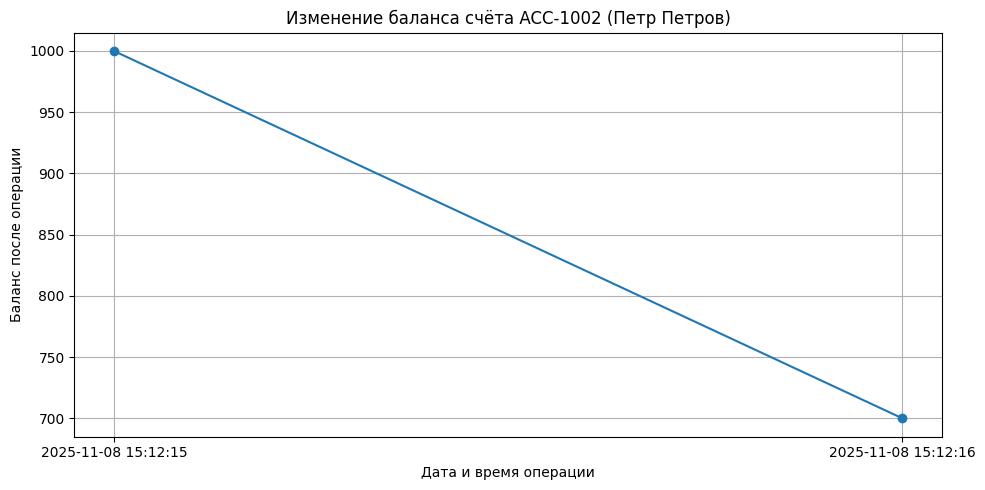

In [89]:
acc.plot_history()

In [ ]:
acc.deposit(400)
acc.withdraw(200)

900.0

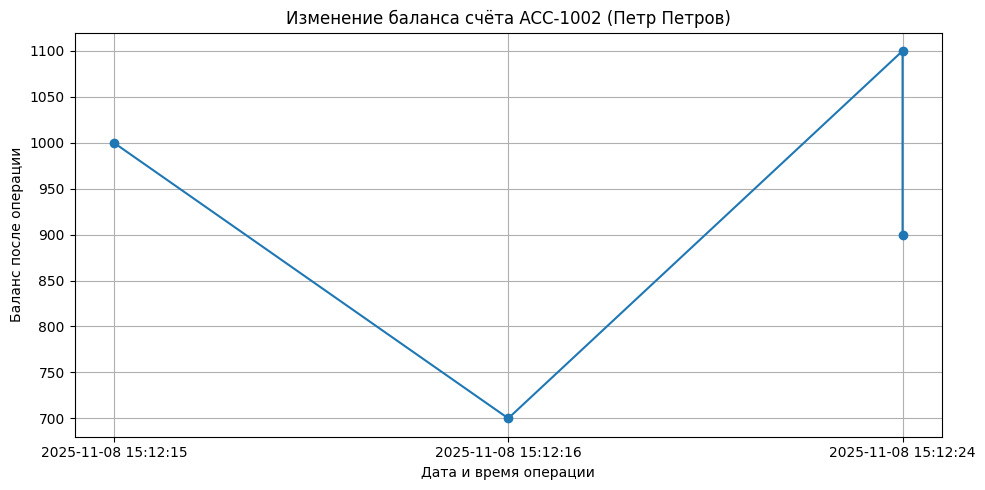

In [ ]:
acc.plot_history()

In [ ]:
acc.withdraw(2000)

ValueError: Недостаточно средств на счёте.

# Задание 2 - Тестирование

In [105]:
if __name__ == "__main__":
    # Проверим загрузку "грязных" данных
    acc = CheckingAccount("иван Иванов")













ValueError: Имя владельца должно быть в формате 'Имя Фамилия'.

In [114]:
acc_check = CheckingAccount("Мария Коваль", 1000)
acc_save = SavingsAccount("Владимир Инь", 1000)

In [115]:
acc_save.withdraw(600)

ValueError: Нельзя снять больше 50% от текущего баланса на сберегательном счёте.

In [116]:
acc_save.withdraw(400)
acc_save.get_balance()

600.0

In [117]:
acc_save.apply_interest(-1)

ValueError: Процентная ставка должна быть положительной.

In [118]:
acc_save.apply_interest(10)
acc_save.get_balance()

660.0

In [119]:
print(acc_save.get_history())

[2025-11-08 15:24:16] Withdraw на 600₽ → баланс: 1000.0₽ (fail)
[2025-11-08 15:24:21] Withdraw на 400₽ → баланс: 600.0₽ (success)
[2025-11-08 15:25:39] Interest на 60.0₽ → баланс: 660.0₽ (success)


In [120]:
acc_save.deposit(1500)

2160.0

In [121]:
acc_save.apply_interest(10)

216.0

In [135]:
acc_save.deposit(400)

2776.0

In [136]:
acc_save.get_large_transactions(5)


Топ-5 крупных операций для Владимир Инь:
2025-11-08 15:26:48 |  deposit |    1500.00 | Баланс:    2160.00 | Статус: success
2025-11-08 15:24:16 | withdraw |     600.00 | Баланс:    1000.00 | Статус: fail
2025-11-08 15:31:31 |  deposit |     400.00 | Баланс:    2776.00 | Статус: success
2025-11-08 15:24:21 | withdraw |     400.00 | Баланс:     600.00 | Статус: success
2025-11-08 15:27:03 | interest |     216.00 | Баланс:    2376.00 | Статус: success


,type,amount,datetime,balance_after,status
3,deposit,1500.0,2025-11-08 15:26:48,2160.0,success
0,withdraw,600.0,2025-11-08 15:24:16,1000.0,fail
5,deposit,400.0,2025-11-08 15:31:31,2776.0,success
1,withdraw,400.0,2025-11-08 15:24:21,600.0,success
4,interest,216.0,2025-11-08 15:27:03,2376.0,success


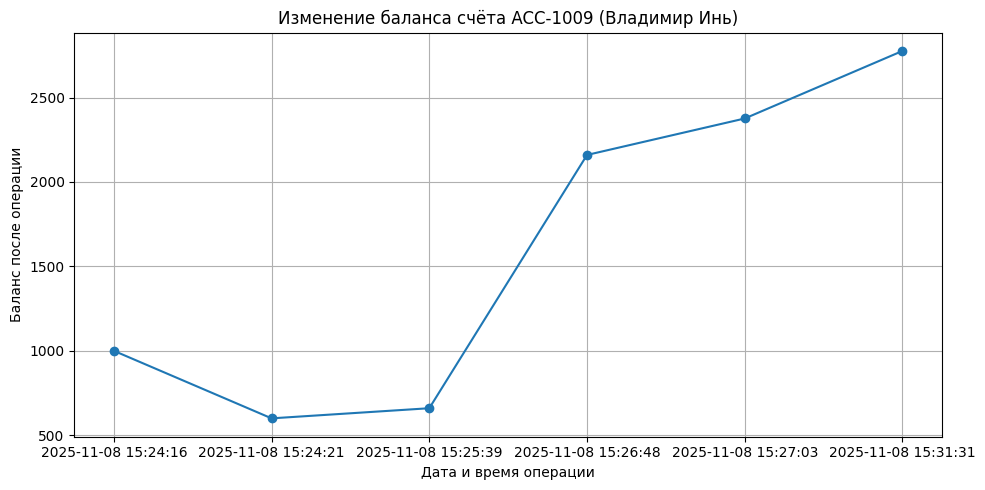

In [137]:
acc_save.plot_history()

# Задание 3 - Тестирование

In [146]:
acc = CheckingAccount("Алексей Вась")
acc.account_number = "ACC-100001"   # <-- подгоняем под файлы
acc.load_history_from_file("/Users/just/Desktop/HSE_DE_1 курс/Python_DE/transactions_dirty.csv")



История загружена (19 операций) для ACC-100001


In [147]:
print(acc.get_history())

[2025-09-27 22:17:26] Deposit на 921.0₽ → баланс: 921.0₽ (success)
[2025-09-27 22:17:26] Deposit на 607.0₽ → баланс: 1528.0₽ (success)
[2025-09-28 22:17:00] Deposit на 129.0₽ → баланс: 1657.0₽ (success)
[2025-09-28 22:17:26] Deposit на 488.0₽ → баланс: 2145.0₽ (success)
[2025-09-29 22:17:26] Deposit на 880.0₽ → баланс: 3025.0₽ (success)
[2025-10-01 22:17:26] Withdraw на 352.0₽ → баланс: 2673.0₽ (success)
[2025-10-01 22:17:26] Withdraw на 65.0₽ → баланс: 2608.0₽ (success)
[2025-10-01 22:17:26] Withdraw на 245.0₽ → баланс: 2363.0₽ (success)
[2025-10-05 22:17:26] Deposit на 327.0₽ → баланс: 2690.0₽ (success)
[2025-10-06 22:17:00] Withdraw на 198.0₽ → баланс: 2492.0₽ (success)
[2025-10-06 22:17:26] Withdraw на 333.0₽ → баланс: 2159.0₽ (success)
[2025-10-12 22:17:26] Deposit на 838.0₽ → баланс: 2997.0₽ (success)
[2025-10-14 22:17:26] Deposit на 532.0₽ → баланс: 3529.0₽ (success)
[2025-10-16 22:17:26] Withdraw на 393.0₽ → баланс: 3136.0₽ (success)
[2025-10-16 22:17:26] Deposit на 701.0₽ → ба


Топ-3 крупных операций для Алексей Вась:
2025-09-27 22:17:26 |  deposit |     921.00 | Баланс:     921.00 | Статус: success
2025-10-19 22:17:26 |  deposit |     916.00 | Баланс:    4187.00 | Статус: succes
2025-09-29 22:17:26 |  deposit |     880.00 | Баланс:    3025.00 | Статус: success


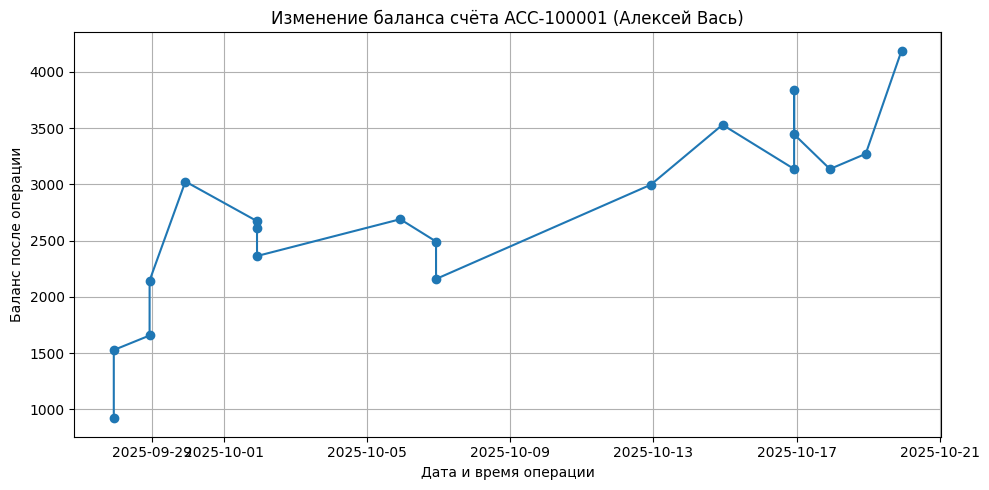

In [148]:
acc.get_large_transactions(3)
acc.plot_history()

In [169]:
save_acc = SavingsAccount("Мария Петрова")
save_acc.account_number = "ACC-100002"   # <-- подгоняем под файлы
save_acc.load_history_from_file("/Users/just/Desktop/HSE_DE_1 курс/Python_DE/transactions_dirty.json")
print(save_acc.get_history())

История загружена (21 операций) для ACC-100002
[2025-09-27 22:17:26] Deposit на 469.0₽ → баланс: 469.0₽ (success)
[2025-09-27 22:17:26] Withdraw на 392.0₽ → баланс: 77.0₽ (success)
[2025-09-28 22:17:26] Deposit на 317.0₽ → баланс: 394.0₽ (success)
[2025-10-02 22:17:26] Deposit на 840.0₽ → баланс: 1234.0₽ (success)
[2025-10-04 22:17:00] Interest на 183.28₽ → баланс: 1417.28₽ (success)
[2025-10-06 22:17:26] Interest на 192.44₽ → баланс: 1609.72₽ (success)
[2025-10-08 22:17:26] Deposit на 426.0₽ → баланс: 2035.72₽ (success)
[2025-10-09 22:17:00] Deposit на 638.0₽ → баланс: 2673.72₽ (success)
[2025-10-09 22:17:00] Deposit на 638.0₽ → баланс: 3311.72₽ (success)
[2025-10-09 22:17:26] Withdraw на 170.0₽ → баланс: 3141.72₽ (success)
[2025-10-09 22:17:26] Deposit на 622.0₽ → баланс: 3763.72₽ (success)
[2025-10-10 22:17:26] Interest на 306.26₽ → баланс: 4069.98₽ (success)
[2025-10-12 22:17:26] Withdraw на 278.0₽ → баланс: 3791.98₽ (success)
[2025-10-13 22:17:26] Withdraw на 440.0₽ → баланс: 3351


Топ-3 крупных операций для Мария Петрова:
2025-10-02 22:17:26 |  deposit |     840.00 | Баланс:    1234.00 | Статус: success
2025-10-09 22:17:00 |  deposit |     638.00 | Баланс:    2673.72 | Статус: success
2025-10-09 22:17:00 |  deposit |     638.00 | Баланс:    3311.72 | Статус: success


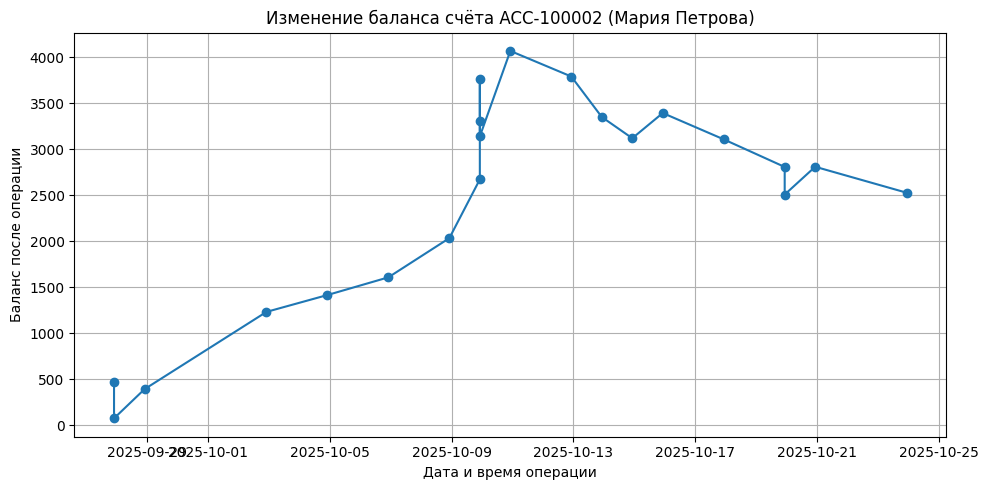

In [170]:
save_acc.get_large_transactions(3)
save_acc.plot_history()